# "Секреты Темнолесья"

Цель проекта — изучить влияние характеристик игроков и их игровых персонажей на
покупку внутриигровой валюты «райские лепестки», а также оценить активность
игроков при совершении внутриигровых покупок

Описание данных:

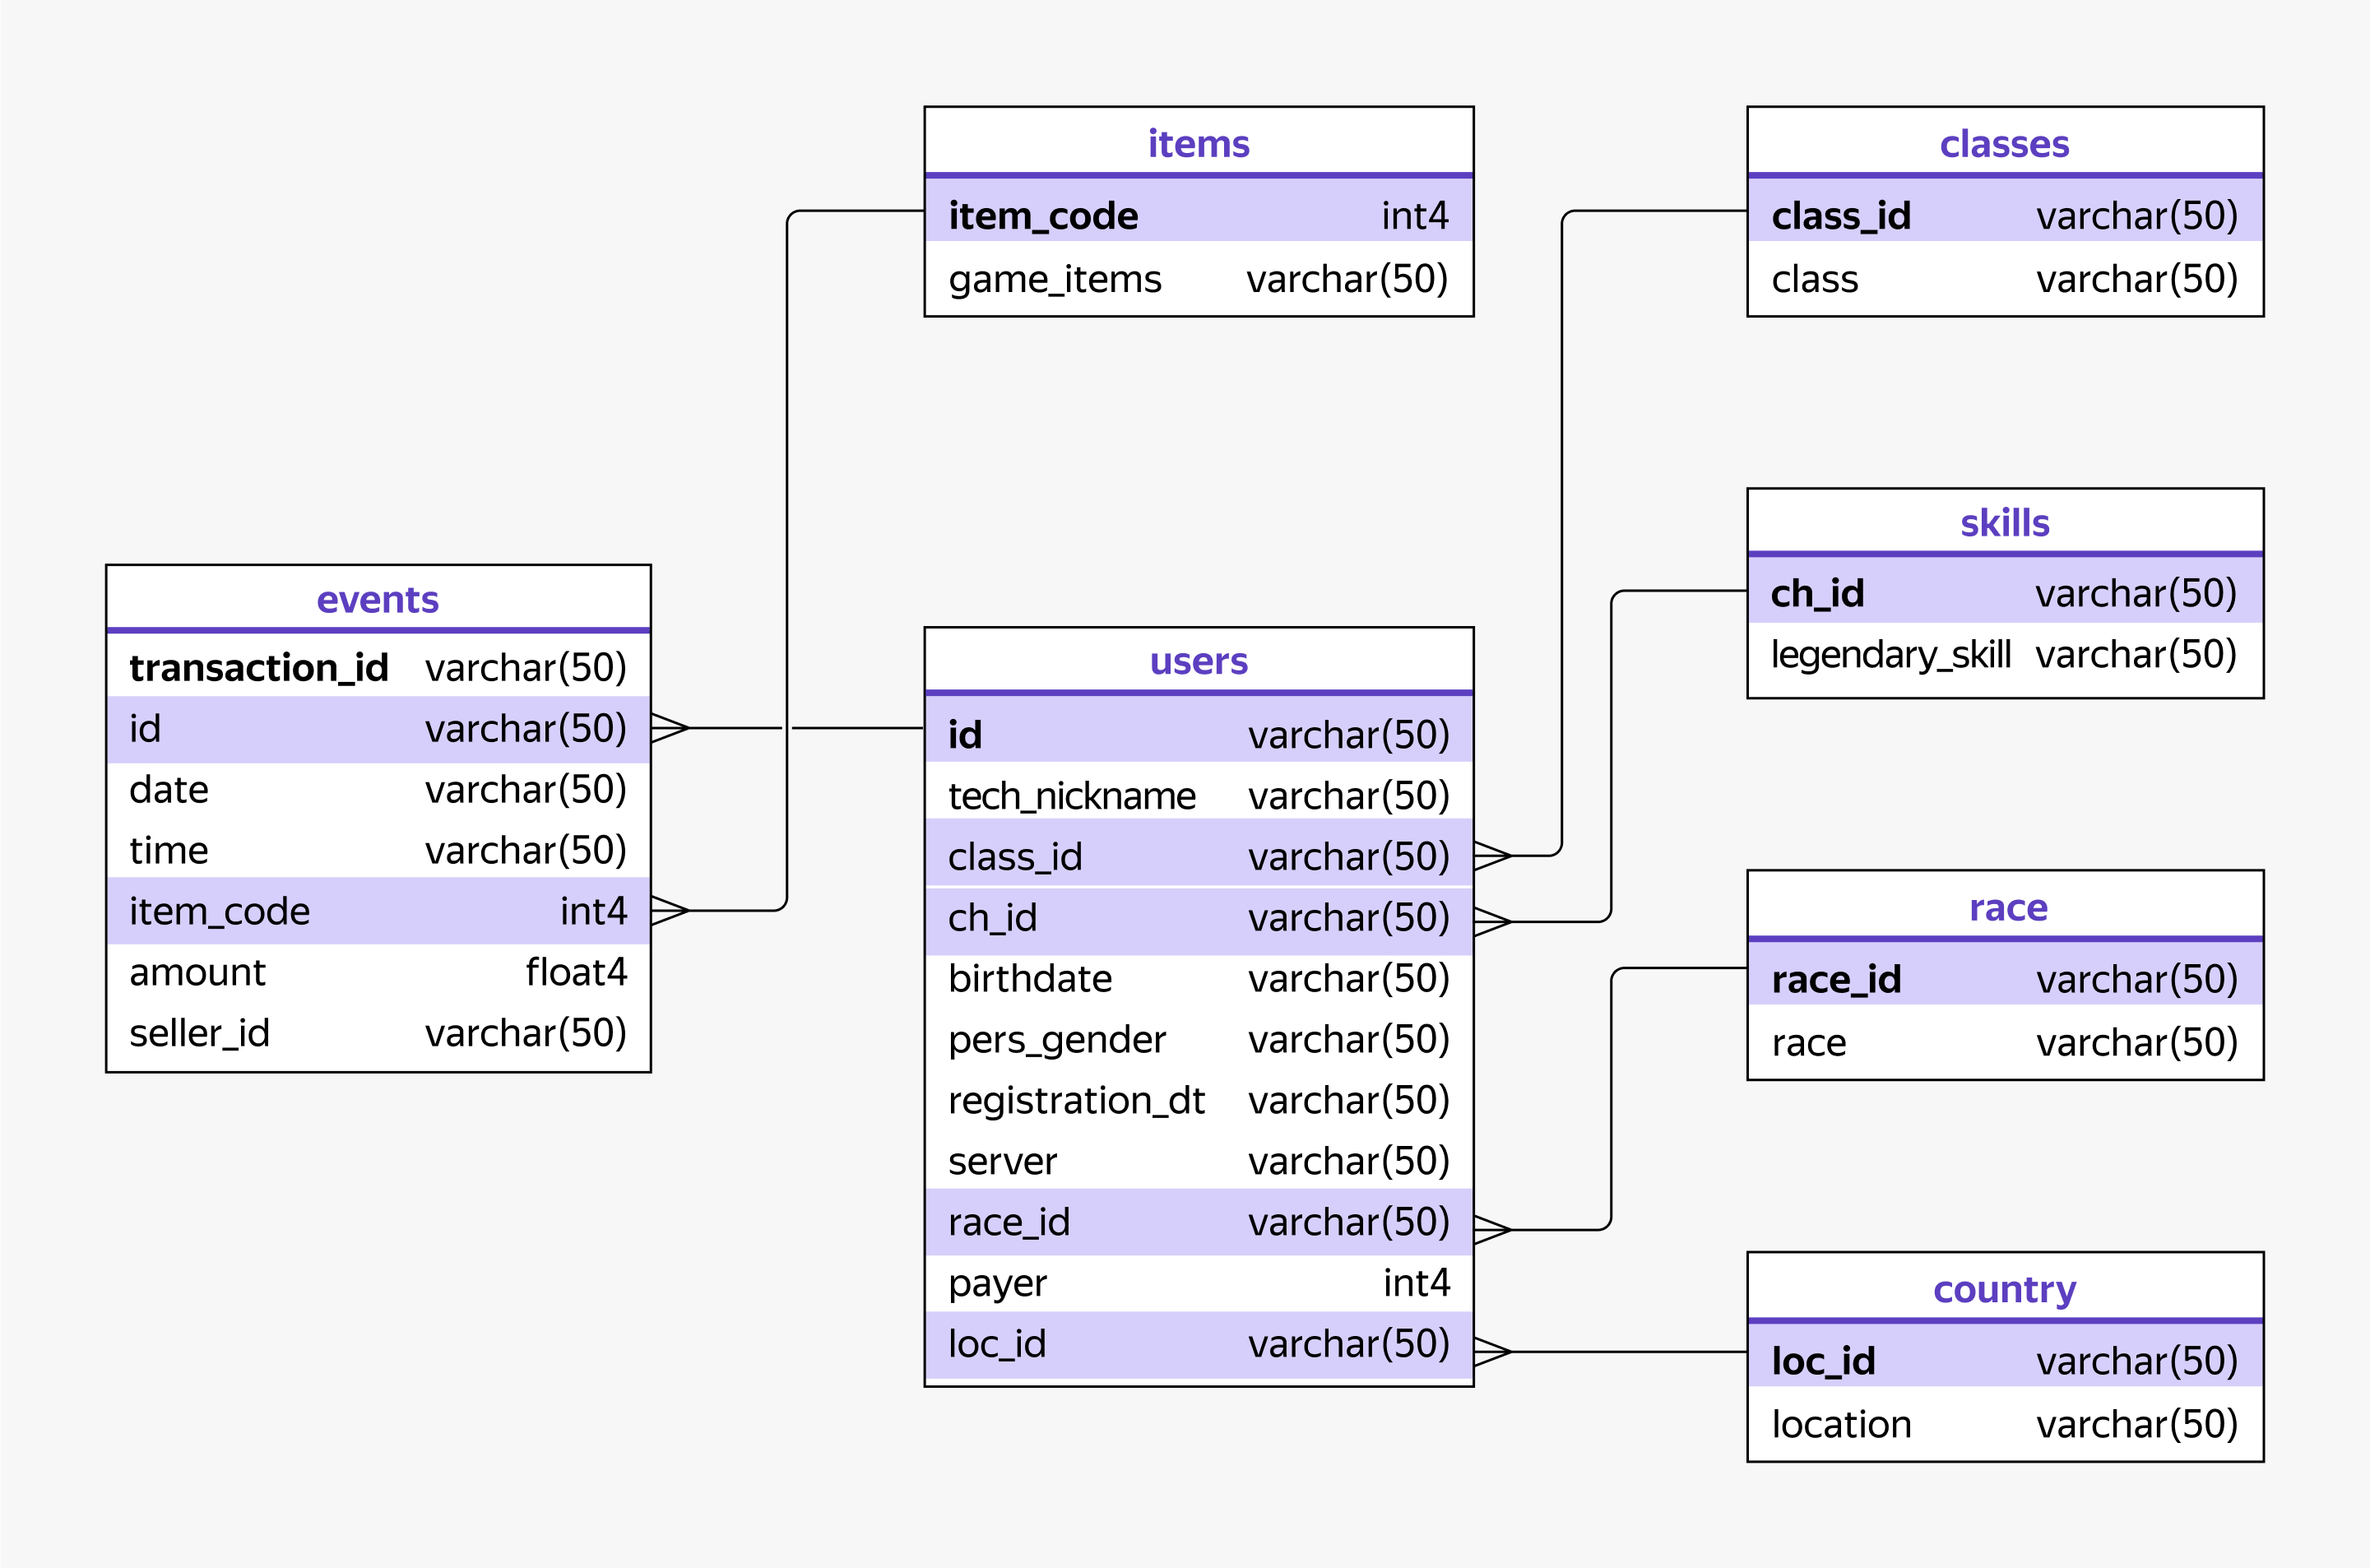

# Table of Contents
* [Подключение к базе данных](#bd)
* [Разведочный анализ данных](#part2)
* [Основная часть](#main)
    * [Исследовательский анализ данных](#eda)
    * [Решение ad-hoc](#adhoc)
* [Общие рекомендации и выводы](#summary)

## Подключение к базе данных <a class="anchor" id="bd"></a>

Выполним подключение к базе данных.

In [1]:
!pip install psycopg2-binary sqlalchemy

In [2]:
from db_secrets import db_config

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

print("Подключение к БД настроено!")

Подключение к БД настроено!


In [3]:
from sqlalchemy import create_engine
engine = create_engine(connection_string)

try:
    with engine.connect() as conn:
        print("Подключение к БД успешно!")
except Exception as e:
    print(f"Ошибка подключения: {e}")

Подключение к БД успешно!


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
class _IntArrayFormatter(pd.io.formats.format.GenericArrayFormatter):

    def _format_strings(self):
        formatter = self.formatter or (lambda x: ' {:,}'.format(x).replace(',', ' '))
        fmt_values = [formatter(x) for x in self.values]
        return fmt_values

pd.io.formats.format.IntArrayFormatter = _IntArrayFormatter

## Разведочный анализ данных <a id="part2"></a>

Необходимо познакомиться с данными об активности игроков. Они хранятся в схеме `fantasy` 

In [6]:
query1 = '''
SELECT table_name
FROM information_schema.tables
WHERE table_schema = 'fantasy';
'''

df_1 = pd.read_sql_query(query1, con=engine)
df_1

,table_name
0,classes
1,country
2,events
3,items
4,race
5,skills
6,users


Схема содержит 7 таблиц, в которых представлена информация об игроах и их активности.

Стоит предположить, что к ключевым таблицам можно отнести users с информацией об игроках и events с информацией о внутриигровых покупках с использованием игровой валюты «райские лепестки». Остальные таблицы содержат более детальную информацию об игроках и эпических предметах. 
Начнёём изучение данных с таблицы users. Получим информацию о названии полей таблицы и типе данных в них, а также присоединим информацию о первичных и внешних ключах.

In [7]:
query2 = '''
SELECT c.table_schema,
       c.table_name,
       c.column_name,
       c.data_type,
       k.constraint_name
FROM information_schema.columns AS c

LEFT JOIN information_schema.key_column_usage AS k 
    ON c.table_name = k.table_name
    AND c.column_name = k.column_name
    AND c.table_schema = k.table_schema

WHERE c.table_schema = 'fantasy'
  AND c.table_name = 'users'
ORDER BY c.table_name;
'''

df_2 = pd.read_sql_query(query2, con=engine)
df_2

,table_schema,table_name,column_name,data_type,constraint_name
0,fantasy,users,id,character varying,users_pkey
1,fantasy,users,tech_nickname,character varying,None
2,fantasy,users,class_id,character varying,users_class_id_fkey
3,fantasy,users,ch_id,character varying,users_ch_id_fkey
4,fantasy,users,birthdate,character varying,None
5,fantasy,users,pers_gender,character varying,None
6,fantasy,users,registration_dt,character varying,None
7,fantasy,users,server,character varying,None
8,fantasy,users,race_id,character varying,users_race_id_fkey
9,fantasy,users,payer,integer,None


Таблица users содержит 11 полей, и большинство из них хранят текстовые данные. При этом поле id с идентификатором игрока — это первичный ключ таблицы, а четыре поля class_id, ch_id, race_id и loc_id — внешние ключи.

Теперь познакомимся с данными — выведем первые пять строк таблицы users. При этом добавим поле row_count с подсчётом общего количества строк в таблице.

In [8]:
query3 = '''
SELECT *,
    COUNT(*) OVER() AS row_count
 FROM fantasy.users
LIMIT 5
'''

df_3 = pd.read_sql_query(query3, con=engine)
df_3

,id,tech_nickname,class_id,ch_id,birthdate,pers_gender,registration_dt,server,race_id,payer,loc_id,row_count
0,00-0037846,DivineBarbarian4154,9RD,JJR2,6/4/1994,Male,1/20/2005,server_1,B1,0,US,22 214
1,00-0041533,BoldInvoker7693,Z3Q,HQ9N,6/29/1987,Male,4/8/2022,server_1,R2,0,US,22 214
2,00-0045747,NobleAlchemist7633,382,IXBW,7/29/1992,Male,10/12/2013,server_1,K3,0,US,22 214
3,00-0055274,SteadfastArcher8318,ZD0,QSUB,9/14/1985,Female,4/10/2008,server_1,R2,0,US,22 214
4,00-0076100,RadiantProphet353,YC8,HQ9N,4/11/1997,Female,9/29/2013,server_2,K4,1,US,22 214


Проверим данные на пропуски

In [9]:
query4 = '''
SELECT COUNT(*)
FROM fantasy.users
WHERE class_id IS NULL
   AND ch_id IS NULL
   AND pers_gender IS NULL
   AND server IS NULL
   AND race_id IS NULL
   AND payer IS NULL
   AND loc_id IS NULL;
'''

df_4 = pd.read_sql_query(query4, con=engine)
df_4

,count
0,0


Пропусков в данных нет.

Переходим к знакомству с категориальными данными таблицы users.Выведем уникальные значения в поле server таблицы users и для каждого сервера найдем количество строк.

In [10]:
query5 = '''
SELECT server, COUNT(*) 
FROM fantasy.users
GROUP BY server
'''

df_5 = pd.read_sql_query(query5, con=engine)
df_5

,server,count
0,server_2,5 499
1,server_1,16 715


Игрокам доступно два сервера. При этом на первом сервере примерно в три раза больше игроков, чем на втором.

Познакомимся с данными ьаблицы events

In [11]:
query6 = '''
-- Выводим названия полей, их тип данных и метку о ключевом поле таблицы events
SELECT c.table_schema,
       c.table_name,
       c.column_name,
       c.data_type,
       k.constraint_name
FROM information_schema.columns AS c 
-- Присоединяем данные с ограничениями полей
LEFT JOIN information_schema.key_column_usage AS k 
    USING(table_name, column_name, table_schema)
-- Фильтруем результат по названию схемы и таблицы
WHERE table_schema = 'fantasy' AND table_name = 'events'
ORDER BY c.table_name;
'''

df_6 = pd.read_sql_query(query6, con=engine)
df_6

,table_schema,table_name,column_name,data_type,constraint_name
0,fantasy,events,transaction_id,character varying,events_pkey
1,fantasy,events,id,character varying,events_id_fkey
2,fantasy,events,date,character varying,None
3,fantasy,events,time,character varying,None
4,fantasy,events,item_code,integer,events_item_code_fkey
5,fantasy,events,amount,real,None
6,fantasy,events,seller_id,character varying,None


Таблица events содержит семь полей, и большинство из них хранит текстовые данные. При этом поле transaction_id с идентификатором транзакции — это первичный ключ таблицы, а два поля id и item_code — внешние ключи, связывающие данные с таблицами users и items.

In [12]:
query7 = '''
SELECT *,
    COUNT(*) OVER() AS row_count
FROM fantasy.events
LIMIT 5
'''

df_7 = pd.read_sql_query(query7, con=engine)
df_7

,transaction_id,id,date,time,item_code,amount,seller_id,row_count
0,2129235853,37-5938126,2021-01-03,16:31:49,6 010,21.41,220381,1 307 678
1,2129237617,37-5938126,2021-01-03,16:49:00,6 010,64.98,54680,1 307 678
2,2129239381,37-5938126,2021-01-03,21:05:29,6 010,50.68,888909,1 307 678
3,2129241145,37-5938126,2021-01-03,22:03:02,6 010,46.49,888902,1 307 678
4,2129242909,37-5938126,2021-01-03,22:04:26,6 010,18.72,888905,1 307 678


Игроки совершили больше миллиона внутриигровых покупок.

Проверим таблицу events на пропуски

In [13]:
query8 = '''
SELECT COUNT(*)
FROM fantasy.events
WHERE date IS NULL
   or time IS NULL
   or amount IS NULL
   or seller_id IS NULL
'''

df_8 = pd.read_sql_query(query8, con=engine)
df_8

,count
0,508 186


В 508186 строках из 1307678 встречаются пропуски хотя бы в одном из полей. Теперь нужно проверить, что это за поля

In [14]:
query9 = '''
-- Считаем количество строк с данными в каждом поле
SELECT 
    COUNT(*) FILTER (WHERE date is not null) AS data_count,
    COUNT(*) FILTER (WHERE time is not null) AS data_time,
    COUNT(*) FILTER (WHERE amount is not null) AS data_amount,
    COUNT(*) FILTER (WHERE seller_id is not null) AS data_seller_id

FROM fantasy.events
WHERE date IS NULL
  OR time IS NULL
  OR amount IS NULL
  OR seller_id IS NULL;
'''

df_9 = pd.read_sql_query(query9, con=engine)
df_9

,data_count,data_time,data_amount,data_seller_id
0,508 186,508 186,508 186,0


Все 508186 пропусков содержатся только в поле seller_id, то есть в данных нет информации о продавце. Видимо, в таком случае покупка совершалась в игровом магазине, а не у других продавцов.

## Основная часть <a class="anchor" id="main"></a>

### Исследовательский анализ данных <a  id="eda"></a>

Доля платящих пользователей по всем данным

In [15]:
query10 = '''
SELECT *, 
    (payers::float/total_users) AS payers_perc
FROM (SELECT 
            COUNT(*) AS total_users,
            COUNT(*) FILTER (WHERE payer=1) AS payers
        FROM fantasy.users
) AS paying_users;
'''

df_10 = pd.read_sql_query(query10, con=engine)
df_10

,total_users,payers,payers_perc
0,22 214,3 929,0.17687


Доля платящих пользователей в разрезе расы персонажа

In [16]:
query11 = '''
SELECT *, 
    (payers_race::float/race_users) AS payers_race_perc
FROM
    (SELECT race AS race,
    COUNT(*) FILTER(WHERE payer = 1) AS payers_race,
    COUNT(*) AS race_users
    FROM fantasy.users AS u LEFT JOIN  fantasy.race AS r USING(race_id)
    GROUP BY race)
AS race_group;
'''

df_11 = pd.read_sql_query(query11, con=engine)
df_11

,race,payers_race,race_users,payers_race_perc
0,Angel,229,1 327,0.172570
1,Elf,427,2 501,0.170732
2,Demon,238,1 229,0.193653
3,Orc,636,3 619,0.175739
4,Human,1 114,6 328,0.176043
5,Northman,626,3 562,0.175744
6,Hobbit,659,3 648,0.180647


Доля платящих пользователей невысокая - около 18 процентов от всех зарегистрированных игроков. Раса не влияет на изменение этого показателя - процентное соотношение платящих игроков в пределах каждой расы остается почти неизменным.

Займёмся исследованием внутриигровых покупок. Для начала расчитаем статистические показатели по полю amount

In [17]:
query12 = '''
SELECT 
	COUNT(*) AS total_purchases,
	SUM(amount) AS total_amount,
	MIN(amount) AS min_amount,
	MAX(amount) AS max_amount,
	AVG(amount) AS avg_amount,
	PERCENTILE_DISC(0.5) WITHIN GROUP(ORDER BY amount) AS mediana,
	STDDEV(amount) AS std_dev
FROM fantasy.events;
'''

df_12 = pd.read_sql_query(query12, con=engine)
df_12

,total_purchases,total_amount,min_amount,max_amount,avg_amount,mediana,std_dev
0,1 307 678,686615040.0,0.0,486615.1,525.691966,74.86,2517.345444


Было совершено 1 307 678 игровых покупок общей стоимостью 686 615 40. Минимальная покупка - 0, максимальная - 486 615,1 Значительно отличаются медиана и среднее значение.

Аномальные нулевые покупки

In [18]:
query13 = '''
SELECT *,
	(free_purchases::float/total_purchases) AS free_purchases_perc
FROM 
	(SELECT 
		COUNT(*) AS total_purchases,
		COUNT(*) FILTER (WHERE amount = 0) AS free_purchases
	FROM fantasy.events) AS free_purch;
'''

df_13 = pd.read_sql_query(query13, con=engine)
df_13

,total_purchases,free_purchases,free_purchases_perc
0,1 307 678,907,0.000694


Аномальными считаются покупки с нулевой стоимостью, они не приносят прибыли разработчикам. Таких покупок 907, их процент среди всех покупок очень мал - всего 0,06 %.

Популярные эпические предметы

In [19]:
query14 = '''
WITH purchases AS (SELECT
	COUNT(transaction_id) FILTER (WHERE amount <> 0) AS total_transactions
	FROM fantasy.events),
buyers AS (SELECT COUNT(DISTINCT id) FILTER (WHERE amount <> 0) AS buyers_count  
	FROM fantasy.events),
events_updated AS (
	SELECT item_code, game_items,
		COUNT(transaction_id) FILTER (WHERE amount <> 0) AS purchases_per_item,
		COUNT(DISTINCT id) FILTER (WHERE amount <> 0) AS unique_buyers
	FROM fantasy.items LEFT JOIN fantasy.events USING(item_code)
	GROUP BY item_code)
SELECT item_code, game_items,
	purchases_per_item,
	(purchases_per_item::float/total_transactions) AS purchases_perc,
	(unique_buyers::float/buyers_count) AS buyers_perc
FROM events_updated CROSS JOIN purchases CROSS JOIN buyers
ORDER BY purchases_per_item desc;
'''

df_14 = pd.read_sql_query(query14, con=engine)
df_14

,item_code,game_items,purchases_per_item,purchases_perc,buyers_perc
0,6 010,Book of Legends,1 004 516,0.768701,0.884136
1,6 011,Bag of Holding,271 875,0.208051,0.867749
2,6 012,Necklace of Wisdom,13 828,0.010582,0.117967
3,6 536,Gems of Insight,3 833,0.002933,0.067140
4,5 964,Treasure Map,3 084,0.002360,0.054597
...,...,...,...,...,...
179,7 531,Troll Blood,0,0.000000,0.000000
180,9 402,Ranger's Bow,0,0.000000,0.000000
181,7 629,Lich's Phylactery,0,0.000000,0.000000
182,5 122,Paralysis Dust,0,0.000000,0.000000


По результатам анализа, самым популярным эпическим предметом оказалась Book of Legends - её покупали целых 1004 516 раз, что составляет 77 процентов от всех продаж. 88 процентов игроков хоть раз купили этот предмет. Ещё одним популярным эпическим предметом оказался Bag of Holding с 271 875 продажами (это 20 процентов от всех покупок. 87 процентов игроков хоть раз купили этот предмет)

### Решение ad-hoc задачи <a  id="adhoc"></a>

Есть гипотеза, что игра за некоторые расы сложнее и требует большего количества покупок эпических предметов, которые помогают в прохождении. Разработчики стремятся убрать различия в прохождении игры между расами так, чтобы не было рас с лёгким прохождением и, наоборот, — с трудным. 

Чтобы ответить на вопрос, посчитаем такие показатели для каждой игровой расы:
- общее количество зарегистрированных игроков;
- количество игроков, которые совершают внутриигровые покупки, и их доля от общего количества зарегистрированных игроков;
- доля платящих игроков среди игроков, которые совершили внутриигровые покупки;
- среднее количество покупок на одного игрока, совершившего внутриигровые покупки;
- средняя стоимость одной покупки на одного игрока, совершившего внутриигровые покупки;
- средняя суммарная стоимость всех покупок на одного игрока, совершившего внутриигровые покупки.

In [20]:
query15 = '''
WITH filtered_events AS (SELECT * 
	FROM fantasy.events WHERE amount <> 0),
users_per_race_cte AS (
	SELECT race_id, race, COUNT(id) AS users_per_race
	FROM fantasy.race LEFT JOIN fantasy.users USING(race_id)
	GROUP BY race_id, race
),
buyers_per_race_cte AS (
	SELECT 
		race_id, 
		COUNT(DISTINCT id) AS buyers
	FROM fantasy.race 
		JOIN fantasy.users USING(race_id)
		JOIN filtered_events USING(id)
	GROUP BY race_id
),
payers_per_buyers_cte AS (
	SELECT 
		race_id, 
		COUNT(DISTINCT u.id) AS payers 
	FROM fantasy.race 
		JOIN fantasy.users AS u USING(race_id) 
		JOIN filtered_events USING(id)
	WHERE payer = 1
	GROUP BY race_id
),
new_events AS (
	SELECT * 
	FROM buyers_per_race_cte JOIN payers_per_buyers_cte USING(race_id)
),
purchases_activity_1 AS (
	SELECT race_id,
		race,
		id,
		COUNT(transaction_id) AS purch_per_user,
		AVG(amount) AS avg_purch_cost_per_user,
		SUM(amount) AS amount_per_user
	FROM fantasy.race LEFT JOIN fantasy.users USING(race_id)
		LEFT JOIN filtered_events USING(id)
	GROUP BY race_id, race, id
),
purchases_activity_2 AS (
	SELECT 
		race_id,
		race,
		AVG(purch_per_user) AS avg_buyer_purch,
		AVG(avg_purch_cost_per_user) AS avg_cost_per_purch,
		AVG(amount_per_user) AS avg_total_buyer_amount
	FROM purchases_activity_1
	WHERE id IS NOT NULL
	GROUP BY race_id, race
),
common_avg AS (
	SELECT race_id, race,
		COUNT(transaction_id) AS tot_purch,
		SUM(amount) AS tot_amnt,
		COUNT(DISTINCT id) AS buyers_race
	FROM fantasy.race JOIN fantasy.users USING(race_id)
		JOIN filtered_events USING(id)
	GROUP BY race_id, race
)
SELECT race_id, upr.race, users_per_race,
	buyers,
	(buyers::float/users_per_race) AS buyers_perc,
	payers,
	(payers::float/buyers) AS payers_perc,
	(tot_amnt::float/tot_purch) AS avg_cost_per_purch,
	(tot_purch::float/buyers_race) AS avg_purch_common,
	(tot_amnt::float/buyers_race) AS avg_total_buyer_amount
FROM users_per_race_cte AS upr LEFT JOIN buyers_per_race_cte USING(race_id)
	LEFT JOIN payers_per_buyers_cte USING(race_id)
	LEFT JOIN purchases_activity_2 USING(race_id) 
	LEFT JOIN common_avg USING(race_id)
ORDER BY race;
'''

df_15 = pd.read_sql_query(query15, con=engine)
df_15

,race_id,race,users_per_race,buyers,buyers_perc,payers,payers_perc,avg_cost_per_purch,avg_purch_common,avg_total_buyer_amount
0,I6,Angel,1 327,820,0.617935,137,0.167073,455.650377,106.804878,48665.682927
1,T7,Demon,1 229,737,0.599675,147,0.199457,529.022025,77.869742,41194.808684
2,B1,Elf,2 501,1 543,0.616953,251,0.162670,682.336223,78.790668,53761.726507
3,K4,Hobbit,3 648,2 266,0.621162,401,0.176964,552.913060,86.128861,47621.772286
4,R2,Human,6 328,3 921,0.619627,706,0.180056,403.082741,121.402193,48935.128794
5,C5,Northman,3 562,2 229,0.625772,406,0.182144,761.471042,82.101839,62518.173172
6,K3,Orc,3 619,2 276,0.628903,396,0.173989,510.912641,81.738137,41761.047452


Доли покупателей примерно равные, но расы различаются по среднему количеству покупок, что отражает активность игроков. В целом процент покупателей среди представителей расы, для каждой из рас примерно одинаковый. В среднем, игроки расы Human покупают гораздо больше эпических предметов нежели игроки других рас. Получается, быть Human’ом сложнее.

## Общие выводы и рекомендации <a class="anchor" id="summary"></a>

Чтобы придерживаться одинакового уровня сложности для каждой из рас, нужно усовершенствовать расу Human. Исходя из популярности эпических предметов Book of Legends и Bag of Holding, можно добавить похожие предметы, но стоимостью выше.